In [1]:
import numpy as np
import cv2
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#
#from keras.optimizers import Adam
import keras.optimizers as optimizers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, TensorBoard

###
import ssd.prior_box as pb
import ssd.tools as tools
from ssd.generator import Generator
from ssd.data_augmenter import DataAugmenter
from ssd.bbox_codec import BBoxCodec

import ssd.ssd_pascal as ssd
from ssd.losses import SsdLoss



# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
################################################################################
img_dir = '../datasets/voc2012/VOCtrainval_11-May-2012/JPEGImages/'
target_img_size = (300, 300)
num_classes = 21
hard_neg_pos_ratio = 3

################################################################################

# Load prepared GroundTruth boxes
gtb = pickle.load(open('data/pascal_voc_2012.p', 'rb'))
img_file_names = shuffle(list(gtb.keys()))
train_samples, valid_samples = train_test_split(img_file_names, test_size=0.1)
print('Train size: {0}'.format(len(train_samples)))
print('Valid size: {0}'.format(len(valid_samples)))

################################################################################
# Prepare Generator
layers_config = ssd.layers_config
prior_boxes = pb.create_prior_boxes_vect(target_img_size[0], target_img_size[1], layers_config, pb.default_prior_variance)
bbox_codec = BBoxCodec(prior_boxes, num_classes)
augmenter = DataAugmenter(target_img_size=target_img_size)
gen = Generator(gtb, img_dir, augmenter, bbox_codec)

# Prepare general data
nb_epoch = 10
batch_size=16

# compile and train the model using the generator function
train_generator = gen.flow(train_samples, batch_size=batch_size)
valid_generator = gen.flow(valid_samples, batch_size=batch_size, do_augment=False)

# calc # of samples per epoch
nb_samples_per_epoch = len(train_samples)
nb_valid_samples = len(valid_samples)

nb_steps_per_epoch = int(nb_samples_per_epoch/batch_size)
nb_valid_steps_per_epoch = max(int(nb_valid_samples/batch_size), 1)

print('nb_steps_per_epoch: {0}'.format(nb_steps_per_epoch))
print('nb_valid_steps_per_epoch: {0}'.format(nb_valid_steps_per_epoch))

################################################################################

base_lr = 2e-5#1e-3#1e-5#1e-3#3e-4
def lr_schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

################################################################################


# general callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
tensor_board = TensorBoard(log_dir='./tb-logs', write_graph=True, write_images=True)
                           #histogram_freq=1,
                           #,embeddings_freq=1)

Train size: 15412
Valid size: 1713
nb_steps_per_epoch: 963
nb_valid_steps_per_epoch: 107


## Create Model with freezed conv layers of the base vgg16

In [ ]:
# Freeze all vgg16 conv layers
freeze_layers_all_vgg16 = ['conv1_1', 'conv1_2', 'pool1',
                         'conv2_1', 'conv2_2', 'pool2',
                         'conv3_1', 'conv3_2', 'conv3_3', 'pool3',
                         'conv4_1', 'conv4_2', 'conv4_3', 'pool4',
                         'conv5_1', 'conv5_2', 'conv5_3', 'pool5'
                         ]

freezed_model = ssd.SSD300(freeze_layers=freeze_layers_all_vgg16, use_bn=False)
freezed_model.summary()

In [ ]:
#################################################################################

#freezed_optimizer=optimizers.Adam(lr=lr)
freezed_optimizer=optimizers.RMSprop(lr=2e-5)
freezed_model.compile(optimizer=freezed_optimizer, loss=SsdLoss(num_classes=num_classes, hard_neg_pos_ratio=hard_neg_pos_ratio).loss)

#################################################################################

# Train when freezed vgg16's conv layers
freezed_model_save_path='models/model.freezed.{epoch:02d}-{val_loss:.2f}.h5'
freezed_checkpoint = ModelCheckpoint(freezed_model_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto')
freezed_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

freezed_history = freezed_model.fit_generator(train_generator, steps_per_epoch=nb_steps_per_epoch, #samples_per_epoch=nb_samples_per_epoch,
                              validation_data=valid_generator, validation_steps=nb_valid_steps_per_epoch, #nb_val_samples=nb_valid_samples,
                              #callbacks=[lr_scheduler, freezed_checkpoint, freezed_early_stopping, tensor_board],
                              #callbacks=[lr_scheduler, freezed_checkpoint, tensor_board],
                              #callbacks=[lr_scheduler, freezed_checkpoint],
                              callbacks=[freezed_checkpoint],
                              #callbacks=[freezed_checkpoint, freezed_early_stopping],
                              epochs=nb_epoch,
                              )


tools.plot_history_curve(freezed_history, "./loss-curve-freezed.png")

## Finetuning

In [ ]:
# Unfreeze top conv layers
freeze_layers = ['conv1_1', 'conv1_2', 'pool1',
                 'conv2_1', 'conv2_2', 'pool2',
                 'conv3_1', 'conv3_2', 'conv3_3', 'pool3',
                 #'conv4_1', 'conv4_2', 'conv4_3', 'pool4',
                 #'conv5_1', 'conv5_2', 'conv5_3', 'pool5'
                 ]

finetuned_model = ssd.SSD300(freeze_layers=freeze_layers, use_bn=False)
finetuned_model.summary()

# Load the best freezed model
#TODO: set the best freezed model path
#best_freezed_model_path = 'models/model.freezed.07-6.42.h5'
#best_freezed_model_path = 'models/model.finetuned.06-5.90.h5'
#best_freezed_model_path = 'models/model.finetuned.06-5.79.h5'
finetuned_model.load_weights(best_freezed_model_path)
# check model again after loading weights
#finetuned_model.summary()

In [ ]:
# Now we can start fine-tuning our network.
# We will do this with the RMSprop optimizer, using a very low learning rate.
# The reason for using a low learning rate is that we want to limit 
# the magnitude of the modifications we make to the representations of the 3 layers 
# that we are fine-tuning.
# Updates that are too large may harm these representations.
# Now let's proceed with fine-tuning:
finetuned_optimizer=optimizers.RMSprop(lr=1e-5)
finetuned_model.compile(optimizer=finetuned_optimizer, loss=SsdLoss(num_classes=num_classes, hard_neg_pos_ratio=hard_neg_pos_ratio).loss)

finetuned_model_save_path='models/model.finetuned.{epoch:02d}-{val_loss:.2f}.h5'
finetuned_checkpoint = ModelCheckpoint(finetuned_model_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto')
finetuned_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

finetuned_history = finetuned_model.fit_generator(train_generator, steps_per_epoch=nb_steps_per_epoch, #samples_per_epoch=nb_samples_per_epoch,
                              validation_data=valid_generator, validation_steps=nb_valid_steps_per_epoch, #nb_val_samples=nb_valid_samples,
                              #callbacks=[lr_scheduler, finetuned_checkpoint, finetuned_early_stopping, tensor_board],
                              #callbacks=[lr_scheduler, finetuned_checkpoint, tensor_board],
                              #callbacks=[lr_scheduler, finetuned_checkpoint],
                              callbacks=[finetuned_checkpoint],
                              #callbacks=[finetuned_checkpoint, finetuned_early_stopping],
                              epochs=nb_epoch,
                              )


tools.plot_history_curve(finetuned_history, "./loss-curve-finetuned.png")

In [60]:
################################################################

#best_freezed_model = ssd.SSD300(freeze_layers=freeze_layers_all_vgg16, use_bn=False)
best_freezed_model = ssd.SSD300(use_bn=False)
best_freezed_model.load_weights('models/freezed1/model.freezed.07-6.42.h5')

################################################################

#best_finetuned_model = ssd.SSD300(freeze_layers=freeze_layers, use_bn=False)
best_finetuned_model = ssd.SSD300(use_bn=False)
#best_finetuned_model.load_weights('models/model.finetuned.06-5.90.h5')
#best_finetuned_model.load_weights('models/model.finetuned.06-5.79.h5')
best_finetuned_model.load_weights('models/finetuned3/model.finetuned.06-5.73.h5')




## Test

In [123]:
import ssd.imaging
import ssd.tools
from ssd.detection import Detection

test_img_file = '2007_000032.jpg' #plane + person
#test_img_file = '2007_000256.jpg' #plane
#test_img_file = '2007_000464.jpg' #cow
#test_img_file = '2007_002462.jpg' #train
test_img_file = '2007_002953.jpg' #bottle

test_img = imaging.load_img(img_dir + test_img_file)

detector = Detection(num_classes, target_img_size, bbox_codec, out_nms_top_k=5, out_conf_threshold=0.8)
imgs, predictions = detector.detect_bboxes(best_finetuned_model, test_img)
print(predictions)

[array([[   5.        ,    0.9606117 ,  174.99999702,   92.5       ,
         500.        ,  277.5       ],
       [   5.        ,    0.96585888,   75.00000298,  129.49999779,
         225.00000894,  370.        ],
       [   5.        ,    0.97688681,   24.86664243,   18.4999989 ,
          75.13335347,   55.49999669],
       [  15.        ,    0.82398105,  237.49999702,  157.24999338,
         500.        ,  370.        ],
       [  15.        ,    0.82633996,  179.5604527 ,    0.        ,
         462.45518327,  370.        ],
       [  15.        ,    0.83897924,    0.        ,   92.81880856,
         500.        ,  254.95805621],
       [  19.        ,    0.80702847,  174.99999702,   55.50000221,
         500.        ,  166.50000662],
       [  19.        ,    0.8209731 ,  125.        ,   92.5       ,
         375.        ,  277.5       ],
       [  19.        ,    0.93067622,  224.99999404,   92.5       ,
         500.        ,  277.5       ]])]


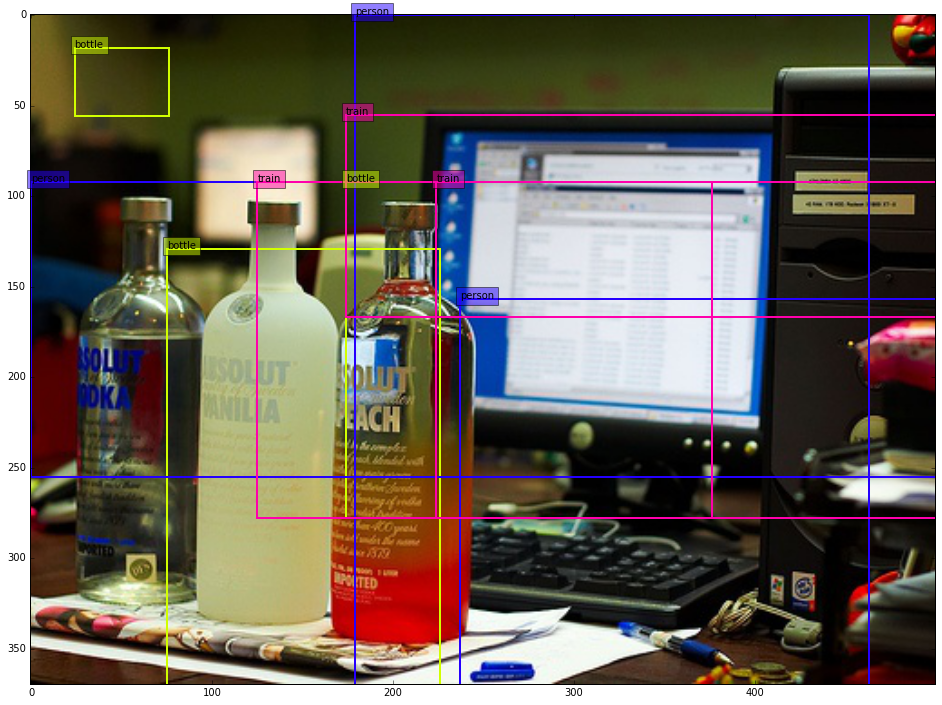

In [124]:
tools.show_bboxes(imgs[0], predictions[0], num_classes)